In [1]:
%load_ext autoreload
%autoreload 2
import importlib
import numpy as np
from plots import *
from processing_funcs import *
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy import stats

In [2]:
# Load dataframe(s) and concatenate (with laptop=False and no dfs_to_load this loads all dataframes with OSC paths)
laptop = False
dfs_to_load = ["All"]
df = load_df(laptop=laptop, dfs_to_load=dfs_to_load)

Loading Pre-2014 Data
Loading Curated Data
Loading Extra Owl
Loading Lots of Data
Loading UWO Data
Loading York Data 1
Loading York Data 2
Loading York Data 3
Combining into one Dataframe!


In [ ]:
# Get spectrum from waveforms
df = process_wfs(df)

In [ ]:
# save processed dataframe
df.to_parquet("processed_df.parquet")

In [ ]:
# load processed dataframe
df = pd.read_parquet("processed_df.parquet")

In [5]:
# Get samples
df_new = get_samples(df)

                                       filepath  \
0         UWO Data\03.06.14\VErearSOAEsupp1.txt   
1      UWO Data\03.06.14\VErearwaveformSOAE.txt   
2         UWO Data\03.11.14\LNrearSOAEsupp1.txt   
3      UWO Data\03.11.14\LNrearwaveformSOAE.txt   
4         UWO Data\09.19.14\RDRearSOAEsupp1.txt   
..                                          ...   
739       York Data\12.06.13\AC9rearSOAEwf4.mat   
740  York Data\12.12.17\ACsb6learSOAEsupp01.txt   
741  York Data\12.12.17\ACsb6learSOAEsupp02.txt   
742  York Data\12.12.17\ACsb6learSOAEsupp03.txt   
743  York Data\12.12.17\ACsb6learSOAEsupp04.txt   

                                                 freqs  \
0    [0.0, 1.34583, 2.69165, 4.03748, 5.3833, 6.729...   
1    [0.0, 1.3458251953125, 2.691650390625, 4.03747...   
2    [0.0, 1.34583, 2.69165, 4.03748, 5.3833, 6.729...   
3    [0.0, 1.3458251953125, 2.691650390625, 4.03747...   
4    [0.0, 1.34583, 2.69165, 4.03748, 5.3833, 6.729...   
..                                     

In [11]:

print(df['filepath'].iloc[35])
print(df['filepath'].iloc[36])

Pre-2014 Data\Geckos et al MIT\05.31.07\BrearSOAEsupp1.txt
Pre-2014 Data\Geckos et al MIT\05.31.07\BrearSOAEwf1.txt


In [12]:
def plot_supp(species=None, num=0, filepath=None, save=False):
    if filepath is None and species is not None:
        row = df[(df['species'] == species) & (df['sr'] == 0)].iloc[num]
    elif filepath is not None:
        row = df.loc[df['filepath'] == filepath].iloc[0]
    elif filepath is None and species is None:
        raise ValueError("We need either a filepath or a species!")
    freqs = row['freqs']
    spectrum = row['spectrum']
    path = Path(row['filepath'])
    species = row['species']
    plt.figure(num)
    plt.plot(freqs/1000, spectrum)
    plt.xlabel("Frequency (kHz)")
    plt.ylabel("dB SPL")
    title = f"{species} SOAE Spectrum ({path.name})"
    plt.title(title)
    if save:
        plt.savefig(path.name + ".png")
    plt.show()

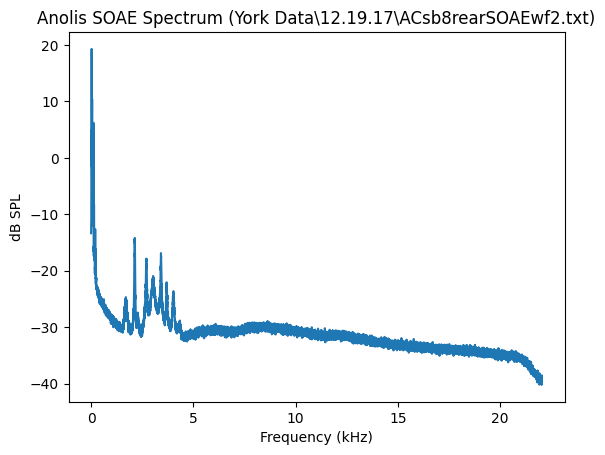

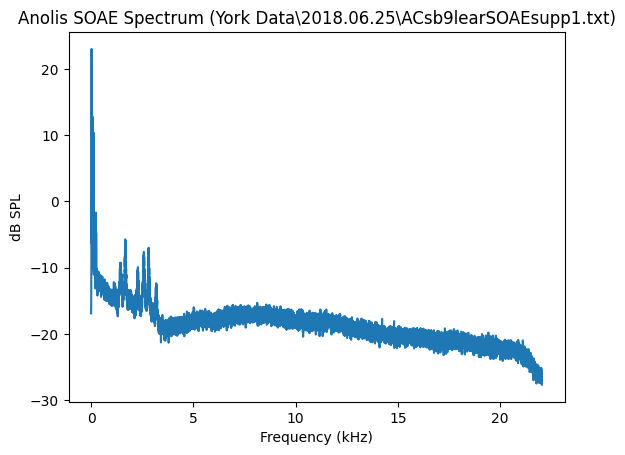

In [97]:
for i in [35, 36]:
    plot_supp(filepath=df['filepath'].iloc[i])

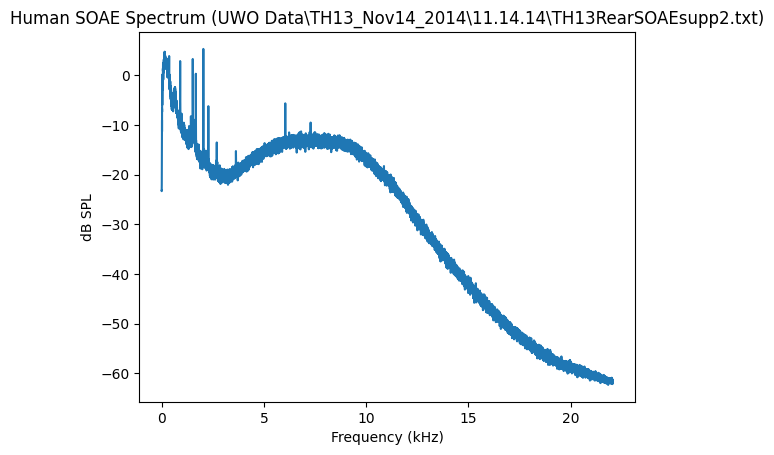

In [90]:
plot_supp("Human", 42, save=True)

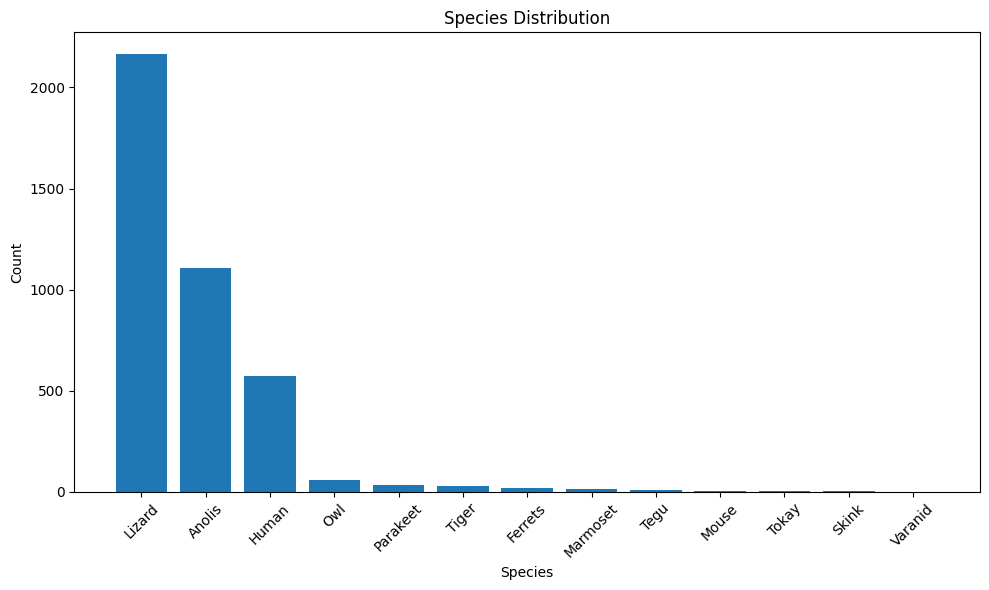

In [4]:
# Get number of each species and plot in a bar chart
species_counts = df[df['species']!=""]['species'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(species_counts.index, species_counts.values)

# Add labels and title
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('Species Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.tight_layout()  # Adjust layout to prevent label cutoff
# plt.savefig('species_distribution.png', dpi=300, bbox_inches='tight')  # Adjust dpi and bounding box
plt.show()



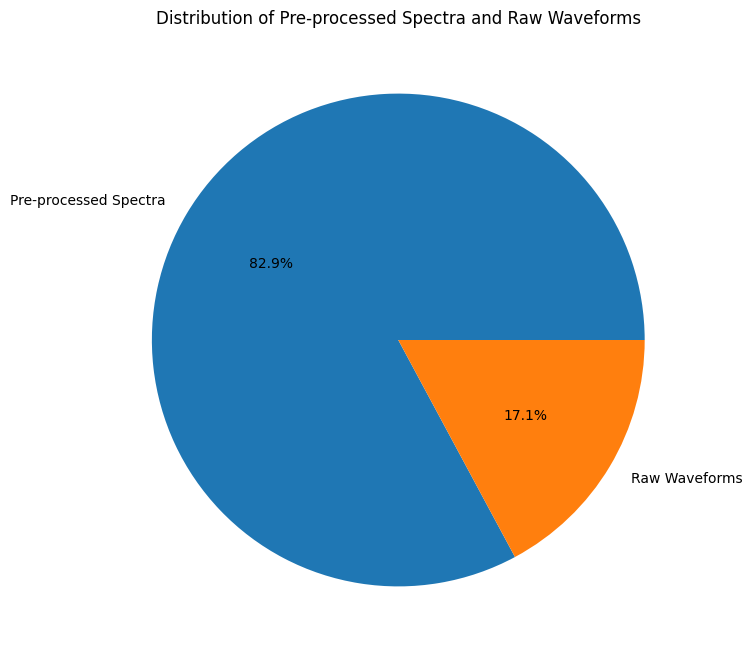

In [5]:
# Get how many are pre-processed
num_preprocessed = (df['sr'] == 0).sum()
num_wf = len(df) - num_preprocessed

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie([num_preprocessed, num_wf], labels=['Pre-processed Spectra', 'Raw Waveforms'], autopct='%1.1f%%')
plt.title('Distribution of Pre-processed Spectra and Raw Waveforms')
# plt.savefig('pp vs wf.png', dpi=300, bbox_inches='tight')  # Adjust dpi and bounding box
plt.show()

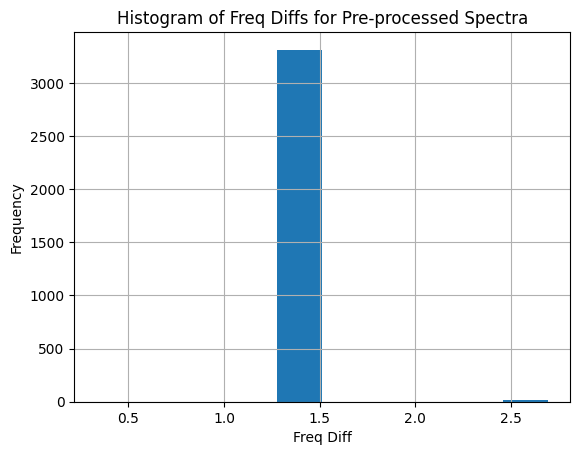

In [6]:
# Out of the preprocessed ones, get a histogram of the spacing between frequency bins
freq_diffs = df[df['sr'] == 0]['freqs'].apply(lambda x: x[100] - x[99])
freq_diffs.hist()
plt.title('Histogram of Freq Diffs for Pre-processed Spectra')
plt.xlabel('Freq Diff')
plt.ylabel('Frequency')
plt.show()

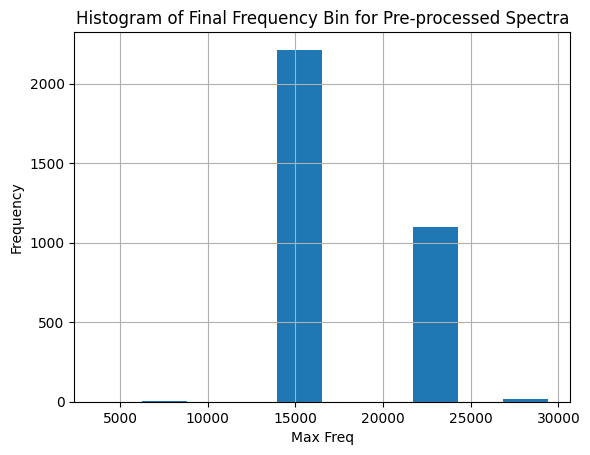

In [7]:
# Out of the preprocessed ones, get a histogram of the maximum frequency bin value
max_freqs = df[df['sr'] == 0]['freqs'].apply(lambda x: x[-1])
max_freqs.hist()
plt.title('Histogram of Final Frequency Bin for Pre-processed Spectra')
plt.xlabel('Max Freq')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_1162/632959221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_supp['max_freq_category'] = max_freqs.apply(lambda x: '< 20000' if x < 20000 else '> 20000')


<Figure size 1200x600 with 0 Axes>

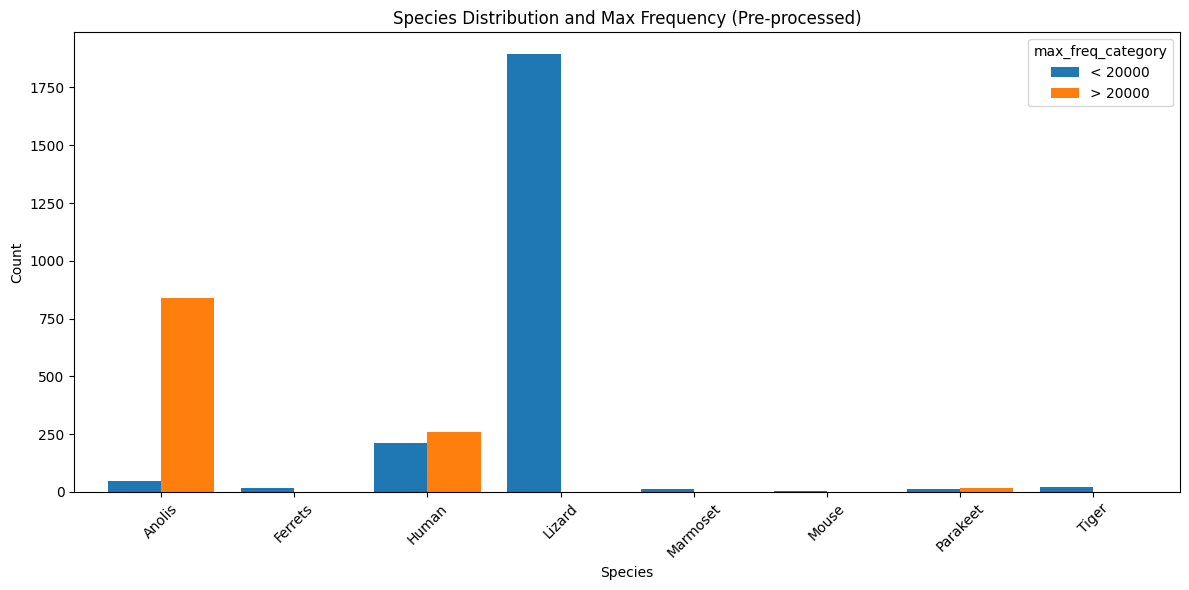

In [8]:
# Calculate max frequencies
df_supp = df[df['sr'] == 0]
max_freqs = df_supp['freqs'].apply(lambda x: x[-1])

# Add a new column to classify max frequencies into categories
df_supp['max_freq_category'] = max_freqs.apply(lambda x: '< 20000' if x < 20000 else '> 20000')

# Filter data for species with non-empty values
species_data = df_supp[df_supp['species'] != ""]

# Group data by species and max_freq_category, and count occurrences
grouped = species_data.groupby(['species', 'max_freq_category']).size().unstack(fill_value=0)

# Plot the double bar graph
plt.figure(figsize=(12, 6))
grouped.plot(kind='bar', width=0.8, figsize=(12, 6))

# Add labels and title
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('Species Distribution and Max Frequency (Pre-processed)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save and show the plot
# plt.savefig('species_max_freq_double_bar.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:

min_freq_length = df['freqs'].apply(len).min()
rows_with_min_freq = df['freqs'].apply(len).eq(min_freq_length).sum()
print(f"{rows_with_min_freq}/ {len(df)}")


2236/ 4024


In [14]:
# target_value = 1.3458
target_value = 1.3
precision = 1  # Round to 5 decimal places
wf_sr = 44100
wf_win = 32768

# Function to compute the difference and round it
def diff_is_target(row):
    # if it's a waveform, calculate freq ax by hand
    if row['sr'] != 0:
        freqs = rfftfreq(wf_win, 1/wf_sr)
    # Otherwise, Get the array from the 'freqs' column
    else:
        freqs = np.array(row['freqs'])
    
    # Ensure there are at least 2 elements to calculate the difference
    if freqs is not None and len(freqs) < 2:
        raise ValueError("Freqs is less than length 2!")
    # check various freq bin diffs
    diffs = [freqs[1] - freqs[0], freqs[100] - freqs[99], freqs[900] - freqs[899]]
    good = True
    for diff in diffs:
        # print(diff)
        if row['sr']!=0:
            print(diff)
        if round(diff, precision) != round(target_value, precision):
            good = False
    return good

# Filter the dataframe
print(f"{len(df[df.apply(diff_is_target, axis=1)])}/ {len(df)}")

1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.3458251953125
1.345825

In [32]:
for idx, row in df.iterrows():
    if row['sr']!=0:
        continue
    print(np.diff(row['freqs'])[10000])

1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000010914
1.3000000000